# STA 208: Homework 2
This is based on the material in Chapters 3, 4.4 of 'Elements of Statistical Learning' (ESL), in addition to lectures 4-6.  Chunzhe Zhang came up with the dataset and the analysis in the second section.

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements (beginning with __Exercise X.X__).  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

In the conceptual exercises you should provide an explanation, with math when necessary, for any answers.  When answering with math you should use basic LaTeX, as in 
$$E(Y|X=x) = \int_{\mathcal{Y}} f_{Y|X}(y|x) dy = \int_{\mathcal{Y}} \frac{f_{Y,X}(y,x)}{f_{X}(x)} dy$$
for displayed equations, and $R_{i,j} = 2^{-|i-j|}$ for inline equations.  (To see the contents of this cell in markdown, double click on it or hit Enter in escape mode.)  To see a list of latex math symbols see here: http://web.ift.uib.no/Teori/KURS/WRK/TeX/symALL.html

# 1. Conceptual Exercises

__Exercise 1.1.__ (5 pts) Ex. 3.29 in ESL 

__Solution:__  
Let $X$ be the $n x p$ feature matrix, and $y$ be the $n$-vector. Then $\hat\beta^{ridge} = min_{\beta}||X\beta - y||^2_2 - \lambda||\beta||^2$, and $\beta = (X^TX + \lambda I)^{-1}X^Ty \Rightarrow \beta = \frac{X^Ty}{X^TX+\lambda}$ in this case.  
Now with $X^*$, the feature matrix is $[XX]_{nx2p}$, so $\hat\beta^{ridge} = min_{\beta}||X\beta_1+X\beta_2-y||^2_2 + \lambda||\beta_1||^2+\lambda||\beta_2||^2$.  
The partial derivative wrt $\beta_1$: $2X^T(X\beta_1+X\beta_2-y)+2\lambda\beta_1=0$  
The partial derivative wrt $\beta_2$: $2X^T(X\beta_1+X\beta_2-y)+2\lambda\beta_2=0$  
$\Rightarrow \beta_1=\beta_2=\frac{X^Ty}{2X^TX+\lambda} = \frac{X^TX+\lambda}{2X^TX+\lambda}\beta$.  
By induction, we can do this for $m$ copies of $X$. 

__Exercise 1.2__ (5 pts) Ex. 3.30 in ESL

__Solution:__  
Let $\tilde X = (X \ \ aI)^T$. Then $\tilde X\beta = (X\beta \ \ a\beta)^T$.  
Let $\tilde y = (y \ \ 0)^T$.  
Then $||\tilde y - \tilde X\beta||^2_2 = ||(y - X\beta \ \ a\beta)^T||^2_2 = ||y - X\beta||^2_2 + a^2||\beta||^2_2$.  
A lasso problem for this is  
$\hat\beta = argmin_\beta(||\tilde y - \tilde X\beta||^2_2 + \tilde \lambda ||\beta||_1)$.  
If we let $a^2 = \lambda \alpha$ and $\tilde \lambda = \lambda (1-\alpha)$, the lasso problem looks like our original problem. 

__Exercise 1.3__ (5 pts) $Y \in \{0,1\}$ follows an exponential family model with natural parameter $\eta$ if
$$P(Y=y) = \exp\left( y \eta - \psi(\eta) \right).$$
Show that when $\eta = x^\top \beta$ then $Y$ follows a logistic regression model.

__Solution:__  
Notice that $P(Y=0)+P(Y=1)=1$ since $Y \in [0,1]$.  
So then $exp(-\psi (x^T\beta)) + exp(x^T\beta - \psi (x^T\beta)) = 1$  
$exp(-\psi (x^T\beta))(1 + exp(x^T\beta)) = 1$  
$exp(-\psi (x^T\beta)) = \frac{1}{1+exp(x^T\beta)}$
$\Rightarrow \psi (x^T\beta) = ln(1+exp(x^T\beta))$  
So $P(Y = y) = exp(yx^T\beta)exp(-ln(1+exp(x^T\beta))) = frac{exp(yx^T\beta)}{1+exp(x^T\beta)}$,  
which is a logistic regression model. 


# 2. Data Analysis

In [102]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


# dataset path
data_dir = "~/Dropbox/208/208-HW2-pamelot317"

Load the following medical dataset with 750 patients. The response variable is survival dates (Y), the predictors are 104 measurements measured at a specific time (numerical variables have been standardized).

In [2]:
sample_data = pd.read_csv(data_dir+"/hw2.csv", delimiter=',')

In [3]:
sample_data.head()

,Y,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104
0,1498,No,0.171838,-0.081764,-1.448868,-1.302547,-0.143061,-0.339784,-1.206475,0.444493,...,-1.379066,0.420436,-0.827446,0.318695,-0.787409,0.351406,-0.836107,0.015502,0.435444,-0.879906
1,334,Yes,-0.605767,-0.584360,-0.485169,-0.848111,-0.493546,-0.392332,-0.239788,0.421697,...,0.398840,-0.434789,-0.698862,1.387219,0.948456,0.191397,1.451699,-1.243616,-0.699072,1.751434
2,845,Yes,-0.266330,-0.126965,0.138401,0.262732,-0.202438,0.397194,0.137790,0.047847,...,-0.450999,-0.627830,0.677158,-0.140255,-0.798641,-0.972419,-0.852035,0.080914,-1.906252,0.705509
3,1484,No,0.113498,0.893293,-0.825298,-0.444168,0.756242,0.179122,-1.145078,-1.471261,...,0.316312,0.131010,0.878134,-0.306249,-1.263270,1.316120,-0.999717,1.104161,-0.234038,-0.083488
4,301,Yes,-0.620454,-0.608036,-0.088352,0.111253,-0.598898,-0.513191,0.753000,1.055418,...,0.364884,0.251667,0.373787,-0.354599,0.085019,1.207509,-0.762206,-0.067318,0.158247,0.592638


In [4]:
sample_data.V1 = sample_data.V1.eq('Yes').mul(1)

The response variable is Y for 2.1-2.3 and Z for 2.4. 

In [5]:
X = np.array(sample_data.iloc[:,range(2,104)])
y = np.array(sample_data.iloc[:,0])
z = np.array(sample_data.iloc[:,1])

__Exercise 2.1__ (10 pts) Perform ridge regression on the method and cross-validate to find the best ridge parameter.

In [168]:
X = scale(X)
alphas = 10**np.linspace(10,-2,100)*0.5
#alphas = np.linspace(30,1,100)
#alphas = np.linspace(1,1e-5,100)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=True)
rcv.fit(X,y)
cv_vals = rcv.cv_values_

In [169]:
rcv.alpha_

0.0050000000000000001

In [170]:
ridge = Ridge(alpha=rcv.alpha_)
ridge.fit(scale(X), y)
pred = ridge.predict(scale(X))
mean_squared_error(y, pred)

242417.70072878039

By experimenting with different sets of alphas in the code, we can see that the best MSE that we can attain is approximately 242417. Even when the best ridge parameter is 0, the MSE is the same. This would indicate that ordinary OLS is better for this data than ridge regression. 

__Exercise 2.2__ (10 pts) Plot the lasso and lars path for each of the coefficients.  All coefficients for a given method should be on the same plot, you should get 2 plots.  What are the major differences, if any?  Are there any 'leaving' events in the lasso path?

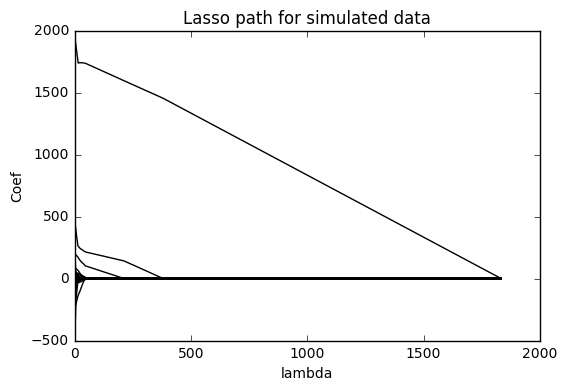

In [115]:
larper = lars_path(X,y,method="lasso")
S = 102
for j in range(S):
    _ = plt.plot(larper[0],larper[2][j,:],'k')
_ = plt.title('Lasso path for simulated data')
_ = plt.xlabel('lambda')
_ = plt.ylabel('Coef')

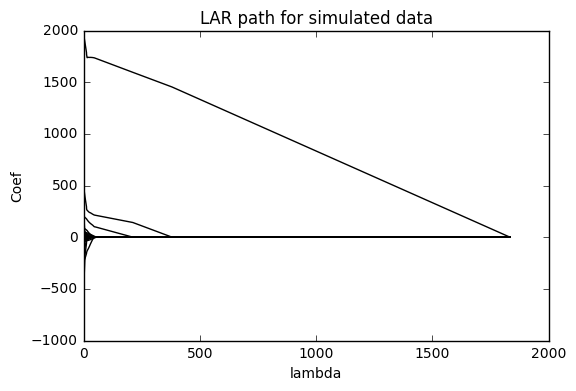

In [116]:
larper1 = lars_path(X,y,method="lar")
S = 102
for j in range(S):
    _ = plt.plot(larper1[0],larper1[2][j,:],'k')
_ = plt.title('LAR path for simulated data')
_ = plt.xlabel('lambda')
_ = plt.ylabel('Coef')

There are no major differences between the two plots, except that the lasso path is thicker at zero, indicating that the coefficients reach zero. We can see that for large lambda values, the coefficients tend towards zero. The very large coefficient takes a long time to tend towards zero.

__Exercise 2.3__ (10 pts) Cross-validate the Lasso and compare the results to the answer to 2.1.

In [171]:
lassocv = LassoCV(alphas=alphas, normalize = True)
lassocv.fit(X,y)

LassoCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [172]:
lassocv.alpha_

1.3280438914733419

In [173]:
lasso = Lasso(max_iter=10000)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X, y)
mean_squared_error(y, lasso.predict(X))

242903.02156754184

The MSE is a little higher than in ridge regression, but the alpha value is higher. 

__Exercise 2.4__ (15 pts) Obtain the 'best' active set from 2.3, and create a new design matrix with only these variables.  Use this to predict the categorical variable $z$ with logistic regression. 

In [174]:
np.where(lassocv.coef_)[0]

array([ 0,  2,  6,  7, 14, 22, 44, 61, 63, 80, 81, 84])

In [175]:
X_a = X[:,np.where(lassocv.coef_)[0]]

In [176]:
X_a.shape

(750, 12)

In [177]:
logistic = LogisticRegression()

In [178]:
logreg = logistic.fit(X_a,z)

In [179]:
logreg.coef_

array([[-2.30690657,  0.14071472,  2.78945497,  0.08728932,  0.28342494,
         0.0154738 ,  0.05191187,  0.08970397, -0.01060178,  0.02845155,
         0.14012701,  0.02108306]])

In [180]:
mean_squared_error(z, logreg.predict(X_a))

0.08666666666666667

Using the best active set from 2.3, we now have only 12 variables in our design matrix. After predicting z with logistic regression, we have an MSE of 0.0866, which is low. 